In [76]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_roc_curve, f1_score, roc_auc_score
from sklearn import linear_model, model_selection, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
import json
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [77]:
#convert json file into csv file
#with open("politifact_clean.json", "r", encoding='utf-8') as inputfile:
#    df = pd.read_json(inputfile)

politifact_data = json.load(open("gdrive/MyDrive/BT4222/Data/politifact_clean.json", "r"))
politifact_clean = pd.DataFrame(politifact_data)

In [78]:
# read politifact_clean.csv into a DataFrame using a relative path
#path = 'politifact_clean.csv'
#politifact_clean = pd.read_csv(path)

#cleaning the csv, filtering out NA values for text column and replacing NA values for title and publisher
politifact_clean = politifact_clean[politifact_clean['text_clean'].notna()]
politifact_clean['title_clean'] = politifact_clean['title_clean'].fillna('none')
politifact_clean['publisher'] = politifact_clean['publisher'].fillna('none')
politifact_clean['title_clean'] = politifact_clean['title_clean'].str.replace(r'[^\x00-\x7F]+', '') 

#description + headline as another column
politifact_clean['text_and_title'] = politifact_clean['text_clean'] + ' '+ politifact_clean['title_clean']

# examine the first row
politifact_clean.head(3)
#politifact_clean.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


,id,text,title,publish_date,source,url,publisher,dataset,label,title_clean,text_clean,published_time,text_and_title
0,politifact13600,WE WILL RIOT! Michelle Obama’s Mom Will Receiv...,WE WILL RIOT! Michelle Obama’s Mom Will Receiv...,NaN,https://web.archive.org,https://web.archive.org/web/20161227034716/htt...,enhlive,politifact,fake,riot michelle obama mom receive 160k year taxp...,riot michelle obama mom receive 160k year taxp...,NaN,riot michelle obama mom receive 160k year taxp...
1,politifact14384,Representative Bob Goodlatte will miss out on ...,"Peter Strzok, FBI Agent in Texting Scandal, Wi...",1.529313e+09,http://nymag.com,https://nymag.com/intelligencer/2018/06/fbi-ag...,Intelligencer,politifact,fake,peter strzok fbi agent texte scandal testify c...,representative bob goodlatte miss fun issue su...,2018-06-18T05:04:37.365-04:00,representative bob goodlatte miss fun issue su...
2,politifact14643,SHARE this story with your friends!\n\n4.8k SH...,San Juan City Council Votes Unanimously To Imp...,1.507850e+09,https://web.archive.org,https://web.archive.org/web/20171016054621/htt...,Daily Feed News,politifact,fake,san juan city council vote unanimously impeach...,share story friend 4.8k share share tweet shar...,2017-10-12T23:15:41+00:00,share story friend 4.8k share share tweet shar...


# SVM

In [79]:
SVM_dict_a = dict()
SVM_dict_b = dict()
SVM_dict_c = dict()
def tokenize_test_SVM(vect, X_train, y_train, X_test, y_test):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use SVM to predict fake vs real
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(X_train_dtm, y_train)
    y_pred_class = SVM.predict(X_test_dtm)
    #print(y_pred_class)
    
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred_class, labels=['fake', 'real'])
    matrix = classification_report(y_test, y_pred_class, labels=['fake', 'real'])
    
    global accuracy, fscore
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    fscore = metrics.f1_score(y_test, y_pred_class, pos_label='real')
    # print the accuracy of its predictions
    print('Accuracy: ', accuracy)
    print('F1 score: ', fscore)
    print(matrix)

In [80]:
def tokenize_test_SVM_enc(vect, X_train, y_train, X_test, y_test):
    X_extra = politifact_clean['publisher']
    y = politifact_clean.label
    X_extra_train, X_rest, y_train, y_rest = train_test_split(X_extra, y, test_size=0.3, random_state=42)
    X_val, X_extra_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)
    X_extra_train = pd.DataFrame(X_extra_train)
    X_extra_test = pd.DataFrame(X_extra_test)
    X_extra_train['publisher'] = X_extra_train['publisher'].astype('str')
    X_extra_test['publisher'] = X_extra_test['publisher'].astype('str')

    enc = OneHotEncoder(handle_unknown = 'ignore')
    enc.fit(X_extra_train)
    X_extra_enc_train = enc.transform(X_extra_train).toarray()
    X_extra_enc_test = enc.transform(X_extra_test).toarray()
    
    # create document-term matrices using the vectorizer
    X_train_set = vect.fit_transform(X_train).toarray()
    X_test_set = vect.transform(X_test).toarray()
    
    X_train_dtm = np.hstack((X_extra_enc_train, X_train_set))
    X_test_dtm = np.hstack((X_extra_enc_test, X_test_set))
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to predict 
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(X_train_dtm, y_train)
    y_pred_class = SVM.predict(X_test_dtm)
    #print(y_pred_class)
    
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred_class, labels=['fake', 'real'])
    matrix = classification_report(y_test, y_pred_class, labels=['fake', 'real'])
    
    global accuracy, fscore
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    fscore = metrics.f1_score(y_test, y_pred_class, pos_label='real')
    # print the accuracy of its predictions
    print('Accuracy: ', accuracy)
    print('F1 score: ', fscore)
    print(matrix)

### text feature

In [81]:
#TD-IDF
X = politifact_clean.text_clean
y = politifact_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_SVM(vect, X_train, y_train, X_test, y_test)
SVM_dict_a['TD-IDF'] = [accuracy, fscore]

Features:  22458
Accuracy:  0.8472222222222222
F1 score:  0.8804347826086957
              precision    recall  f1-score   support

        fake       0.91      0.69      0.79        59
        real       0.82      0.95      0.88        85

    accuracy                           0.85       144
   macro avg       0.86      0.82      0.83       144
weighted avg       0.86      0.85      0.84       144



In [82]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_SVM(vect, X_train, y_train, X_test, y_test)
SVM_dict_a['CV'] = [accuracy, fscore]

Features:  22458
Accuracy:  0.7013888888888888
F1 score:  0.7455621301775148
              precision    recall  f1-score   support

        fake       0.63      0.64      0.64        59
        real       0.75      0.74      0.75        85

    accuracy                           0.70       144
   macro avg       0.69      0.69      0.69       144
weighted avg       0.70      0.70      0.70       144



In [83]:
#Bi-grams
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
tokenize_test_SVM(bigram_converter, X_train, y_train, X_test, y_test)
SVM_dict_a['Bigrams'] = [accuracy, fscore]
SVM_dict_a

Features:  4584
Accuracy:  0.7430555555555556
F1 score:  0.7861271676300577
              precision    recall  f1-score   support

        fake       0.70      0.66      0.68        59
        real       0.77      0.80      0.79        85

    accuracy                           0.74       144
   macro avg       0.73      0.73      0.73       144
weighted avg       0.74      0.74      0.74       144



{'Bigrams': [0.7430555555555556, 0.7861271676300577],
 'CV': [0.7013888888888888, 0.7455621301775148],
 'TD-IDF': [0.8472222222222222, 0.8804347826086957]}

### title + text feature

In [84]:
#TD-IDF
X = politifact_clean.text_and_title
y = politifact_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_SVM(vect, X_train, y_train, X_test, y_test)
SVM_dict_b['TD-IDF'] = [accuracy, fscore]

Features:  22566
Accuracy:  0.8472222222222222
F1 score:  0.8749999999999999
              precision    recall  f1-score   support

        fake       0.85      0.76      0.80        59
        real       0.85      0.91      0.87        85

    accuracy                           0.85       144
   macro avg       0.85      0.83      0.84       144
weighted avg       0.85      0.85      0.85       144



In [85]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_SVM(vect, X_train, y_train, X_test, y_test)
SVM_dict_b['CV'] = [accuracy, fscore]

Features:  22566
Accuracy:  0.7777777777777778
F1 score:  0.8095238095238095
              precision    recall  f1-score   support

        fake       0.72      0.75      0.73        59
        real       0.82      0.80      0.81        85

    accuracy                           0.78       144
   macro avg       0.77      0.77      0.77       144
weighted avg       0.78      0.78      0.78       144



In [86]:
#Bi-grams
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
tokenize_test_SVM(bigram_converter, X_train, y_train, X_test, y_test)
SVM_dict_b['Bigrams'] = [accuracy, fscore]
SVM_dict_b

Features:  4585
Accuracy:  0.7569444444444444
F1 score:  0.7976878612716763
              precision    recall  f1-score   support

        fake       0.71      0.68      0.70        59
        real       0.78      0.81      0.80        85

    accuracy                           0.76       144
   macro avg       0.75      0.74      0.75       144
weighted avg       0.76      0.76      0.76       144



{'Bigrams': [0.7569444444444444, 0.7976878612716763],
 'CV': [0.7777777777777778, 0.8095238095238095],
 'TD-IDF': [0.8472222222222222, 0.8749999999999999]}

### publisher and text_and_title

In [87]:
#TD-IDF
X = politifact_clean.text_and_title
y = politifact_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_SVM_enc(vect, X_train, y_train, X_test, y_test)
SVM_dict_c['TD-IDF'] = [accuracy, fscore]

Features:  22764
Accuracy:  0.8402777777777778
F1 score:  0.8700564971751413
              precision    recall  f1-score   support

        fake       0.85      0.75      0.79        59
        real       0.84      0.91      0.87        85

    accuracy                           0.84       144
   macro avg       0.84      0.83      0.83       144
weighted avg       0.84      0.84      0.84       144



In [88]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_SVM_enc(vect, X_train, y_train, X_test, y_test)
SVM_dict_c['CV'] = [accuracy, fscore]

Features:  22764
Accuracy:  0.8055555555555556
F1 score:  0.8390804597701149
              precision    recall  f1-score   support

        fake       0.78      0.73      0.75        59
        real       0.82      0.86      0.84        85

    accuracy                           0.81       144
   macro avg       0.80      0.79      0.80       144
weighted avg       0.80      0.81      0.80       144



In [89]:
#Bi-grams
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
tokenize_test_SVM_enc(bigram_converter, X_train, y_train, X_test, y_test)
SVM_dict_c['Bigrams'] = [accuracy, fscore]
SVM_dict_c

Features:  4783
Accuracy:  0.7430555555555556
F1 score:  0.7909604519774012
              precision    recall  f1-score   support

        fake       0.71      0.63      0.67        59
        real       0.76      0.82      0.79        85

    accuracy                           0.74       144
   macro avg       0.74      0.73      0.73       144
weighted avg       0.74      0.74      0.74       144



{'Bigrams': [0.7430555555555556, 0.7909604519774012],
 'CV': [0.8055555555555556, 0.8390804597701149],
 'TD-IDF': [0.8402777777777778, 0.8700564971751413]}

# Logistic Regression

In [90]:
LR_dict_a = dict()
LR_dict_b = dict()
LR_dict_c = dict()
def tokenize_test_LogR(vect, X_train, y_train, X_test, y_test):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Logistic Regression to predict fake vs real
    LogR = LogisticRegression()
    LogR.fit(X_train_dtm, y_train)
    y_pred_class = LogR.predict(X_test_dtm)
    #print(y_pred_class)
    
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred_class, labels=['fake', 'real'])
    matrix = classification_report(y_test, y_pred_class, labels=['fake', 'real'])
    
    global accuracy, fscore
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    fscore = metrics.f1_score(y_test, y_pred_class, pos_label='real')
    # print the accuracy of its predictions
    print('Accuracy: ', accuracy)
    print('F1 score: ', fscore)
    print(matrix)
    return LogR

In [91]:
def tokenize_test_LogR_enc(vect, X_train, y_train, X_test, y_test):
    X_extra = politifact_clean['publisher']
    y = politifact_clean.label
    X_extra_train, X_rest, y_train, y_rest = train_test_split(X_extra, y, test_size=0.3, random_state=42)
    X_val, X_extra_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)
    X_extra_train = pd.DataFrame(X_extra_train)
    X_extra_test = pd.DataFrame(X_extra_test)
    X_extra_train['publisher'] = X_extra_train['publisher'].astype('str')
    X_extra_test['publisher'] = X_extra_test['publisher'].astype('str')

    enc = OneHotEncoder(handle_unknown = 'ignore')
    enc.fit(X_extra_train)
    X_extra_enc_train = enc.transform(X_extra_train).toarray()
    X_extra_enc_test = enc.transform(X_extra_test).toarray()
    
    # create document-term matrices using the vectorizer
    X_train_set = vect.fit_transform(X_train).toarray()
    X_test_set = vect.transform(X_test).toarray()
    
    X_train_dtm = np.hstack((X_extra_enc_train, X_train_set))
    X_test_dtm = np.hstack((X_extra_enc_test, X_test_set))
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to predict 
    LogR = LogisticRegression()
    LogR.fit(X_train_dtm, y_train)
    y_pred_class = LogR.predict(X_test_dtm)
    #print(y_pred_class)
    
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred_class, labels=['fake', 'real'])
    matrix = classification_report(y_test, y_pred_class, labels=['fake', 'real'])
    
    global accuracy, fscore
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    fscore = metrics.f1_score(y_test, y_pred_class, pos_label='real')
    # print the accuracy of its predictions
    print('Accuracy: ', accuracy)
    print('F1 score: ', fscore)
    print(matrix)
    return LogR

### text feature

In [92]:
#TD-IDF
X = politifact_clean.text_clean
y = politifact_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
model = tokenize_test_LogR(vect, X_train, y_train, X_test, y_test)
LR_dict_a['TD-IDF'] = [accuracy, fscore]

Features:  22458
Accuracy:  0.7777777777777778
F1 score:  0.836734693877551
              precision    recall  f1-score   support

        fake       0.91      0.51      0.65        59
        real       0.74      0.96      0.84        85

    accuracy                           0.78       144
   macro avg       0.82      0.74      0.74       144
weighted avg       0.81      0.78      0.76       144



In [93]:
def get_most_impt_features_lr(coefs, features):
    idx_coefs = list(enumerate(model.coef_[0]))
    negative = list(map(lambda x: features[x[0]], sorted(idx_coefs, key=lambda x: x[1])[:5]))
    positive = list(map(lambda x: features[x[0]], sorted(idx_coefs, key=lambda x: x[1], reverse=True)[:5]))
    return positive, negative

In [94]:
get_most_impt_features_lr(model.coef_[0], vect.get_feature_names_out())

(['percent', 'health', 'browser', 'think', 'mccain'],
 ['trump', 'domain', 'trendolizer', 'comment', 'like'])

In [95]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_LogR(vect, X_train, y_train, X_test, y_test)
LR_dict_a['CV'] = [accuracy, fscore]

Features:  22458
Accuracy:  0.7847222222222222
F1 score:  0.8208092485549133
              precision    recall  f1-score   support

        fake       0.75      0.71      0.73        59
        real       0.81      0.84      0.82        85

    accuracy                           0.78       144
   macro avg       0.78      0.77      0.78       144
weighted avg       0.78      0.78      0.78       144



In [96]:
#Bi-grams
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
tokenize_test_LogR(bigram_converter, X_train, y_train, X_test, y_test)
LR_dict_a['Bigrams'] = [accuracy, fscore]
LR_dict_a

Features:  4584
Accuracy:  0.7847222222222222
F1 score:  0.8306010928961749
              precision    recall  f1-score   support

        fake       0.80      0.63      0.70        59
        real       0.78      0.89      0.83        85

    accuracy                           0.78       144
   macro avg       0.79      0.76      0.77       144
weighted avg       0.79      0.78      0.78       144



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'Bigrams': [0.7847222222222222, 0.8306010928961749],
 'CV': [0.7847222222222222, 0.8208092485549133],
 'TD-IDF': [0.7777777777777778, 0.836734693877551]}

### title + text feature

In [97]:
#TD-IDF
X = politifact_clean.text_and_title
y = politifact_clean.label
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=1, stratify=y)

vect = TfidfVectorizer()
tokenize_test_LogR(vect, X_train, y_train, X_test, y_test)
LR_dict_b['TD-IDF'] = [accuracy, fscore]

Features:  22996
Accuracy:  0.8661087866108786
F1 score:  0.8933333333333333
              precision    recall  f1-score   support

        fake       0.94      0.73      0.82       100
        real       0.83      0.96      0.89       139

    accuracy                           0.87       239
   macro avg       0.88      0.85      0.86       239
weighted avg       0.88      0.87      0.86       239



In [98]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_LogR(vect, X_train, y_train, X_test, y_test)
LR_dict_b['CV'] = [accuracy, fscore]

Features:  22996
Accuracy:  0.8577405857740585
F1 score:  0.8794326241134752
              precision    recall  f1-score   support

        fake       0.84      0.81      0.83       100
        real       0.87      0.89      0.88       139

    accuracy                           0.86       239
   macro avg       0.86      0.85      0.85       239
weighted avg       0.86      0.86      0.86       239



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [99]:
#Bi-grams
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
tokenize_test_LogR(bigram_converter, X_train, y_train, X_test, y_test)
LR_dict_b['bigrams'] = [accuracy, fscore]
LR_dict_b

Features:  4658
Accuracy:  0.8326359832635983
F1 score:  0.8561151079136691
              precision    recall  f1-score   support

        fake       0.80      0.80      0.80       100
        real       0.86      0.86      0.86       139

    accuracy                           0.83       239
   macro avg       0.83      0.83      0.83       239
weighted avg       0.83      0.83      0.83       239



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'CV': [0.8577405857740585, 0.8794326241134752],
 'TD-IDF': [0.8661087866108786, 0.8933333333333333],
 'bigrams': [0.8326359832635983, 0.8561151079136691]}

### publisher and text_and_title

In [100]:
#TD-IDF
X = politifact_clean.text_and_title
y = politifact_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_LogR_enc(vect, X_train, y_train, X_test, y_test)
LR_dict_c['TD-IDF'] = [accuracy, fscore]

Features:  22764
Accuracy:  0.8055555555555556
F1 score:  0.8426966292134832
              precision    recall  f1-score   support

        fake       0.80      0.69      0.75        59
        real       0.81      0.88      0.84        85

    accuracy                           0.81       144
   macro avg       0.81      0.79      0.79       144
weighted avg       0.81      0.81      0.80       144



In [101]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_LogR_enc(vect, X_train, y_train, X_test, y_test)
LR_dict_c['CV'] = [accuracy, fscore]

Features:  22764
Accuracy:  0.8333333333333334
F1 score:  0.8604651162790696
              precision    recall  f1-score   support

        fake       0.81      0.78      0.79        59
        real       0.85      0.87      0.86        85

    accuracy                           0.83       144
   macro avg       0.83      0.83      0.83       144
weighted avg       0.83      0.83      0.83       144



In [102]:
#Bi-grams
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
tokenize_test_LogR_enc(bigram_converter, X_train, y_train, X_test, y_test)
LR_dict_c['Bigrams'] = [accuracy, fscore]
LR_dict_c

Features:  4783
Accuracy:  0.8194444444444444
F1 score:  0.8505747126436781
              precision    recall  f1-score   support

        fake       0.80      0.75      0.77        59
        real       0.83      0.87      0.85        85

    accuracy                           0.82       144
   macro avg       0.82      0.81      0.81       144
weighted avg       0.82      0.82      0.82       144



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'Bigrams': [0.8194444444444444, 0.8505747126436781],
 'CV': [0.8333333333333334, 0.8604651162790696],
 'TD-IDF': [0.8055555555555556, 0.8426966292134832]}

# Naive Bayes

In [103]:
NB_dict_a = dict()
NB_dict_b = dict()
NB_dict_c = dict()
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test_NB(vect, X_train, y_train, X_test, y_test):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to predict fake vs real
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    #print(y_pred_class)
    
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred_class, labels=['fake', 'real'])
    matrix = classification_report(y_test, y_pred_class, labels=['fake', 'real'])
    
    global accuracy, fscore
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    fscore = metrics.f1_score(y_test, y_pred_class, pos_label='real')
    # print the accuracy of its predictions
    print('Accuracy: ', accuracy)
    print('F1 score: ', fscore)
    print(matrix)

In [104]:
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test_NB_enc(vect, X_train, y_train, X_test, y_test):
    X_extra = politifact_clean['publisher']
    y = politifact_clean.label
    X_extra_train, X_rest, y_train, y_rest = train_test_split(X_extra, y, test_size=0.3, random_state=42)
    X_val, X_extra_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)
    X_extra_train = pd.DataFrame(X_extra_train)
    X_extra_test = pd.DataFrame(X_extra_test)
    X_extra_train['publisher'] = X_extra_train['publisher'].astype('str')
    X_extra_test['publisher'] = X_extra_test['publisher'].astype('str')

    enc = OneHotEncoder(handle_unknown = 'ignore')
    enc.fit(X_extra_train)
    X_extra_enc_train = enc.transform(X_extra_train).toarray()
    X_extra_enc_test = enc.transform(X_extra_test).toarray()
    
    # create document-term matrices using the vectorizer
    X_train_set = vect.fit_transform(X_train).toarray()
    X_test_set = vect.transform(X_test).toarray()
    
    X_train_dtm = np.hstack((X_extra_enc_train, X_train_set))
    X_test_dtm = np.hstack((X_extra_enc_test, X_test_set))
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to predict 
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    #print(y_pred_class)
    
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred_class, labels=['fake', 'real'])
    matrix = classification_report(y_test, y_pred_class, labels=['fake', 'real'])
    
    global accuracy, fscore
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    fscore = metrics.f1_score(y_test, y_pred_class, pos_label='real')
    # print the accuracy of its predictions
    print('Accuracy: ', accuracy)
    print('F1 score: ', fscore)
    print(matrix)


### text feature

In [105]:
#TD-IDF
X = politifact_clean.text_clean
y = politifact_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_NB(vect, X_train, y_train, X_test, y_test)
NB_dict_a['TD-IDF'] = [accuracy, fscore]

Features:  22458
Accuracy:  0.6666666666666666
F1 score:  0.7777777777777778
              precision    recall  f1-score   support

        fake       0.92      0.20      0.33        59
        real       0.64      0.99      0.78        85

    accuracy                           0.67       144
   macro avg       0.78      0.60      0.56       144
weighted avg       0.76      0.67      0.60       144



In [106]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_NB(vect, X_train, y_train, X_test, y_test)
NB_dict_a['CV'] = [accuracy, fscore]

Features:  22458
Accuracy:  0.7777777777777778
F1 score:  0.8202247191011236
              precision    recall  f1-score   support

        fake       0.76      0.66      0.71        59
        real       0.78      0.86      0.82        85

    accuracy                           0.78       144
   macro avg       0.77      0.76      0.76       144
weighted avg       0.78      0.78      0.77       144



In [107]:
#Bi-grams
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
tokenize_test_NB(bigram_converter, X_train, y_train, X_test, y_test)
NB_dict_a['Bi-grams'] = [accuracy, fscore]
NB_dict_a

Features:  4584
Accuracy:  0.7430555555555556
F1 score:  0.7999999999999999
              precision    recall  f1-score   support

        fake       0.75      0.56      0.64        59
        real       0.74      0.87      0.80        85

    accuracy                           0.74       144
   macro avg       0.74      0.71      0.72       144
weighted avg       0.74      0.74      0.73       144



{'Bi-grams': [0.7430555555555556, 0.7999999999999999],
 'CV': [0.7777777777777778, 0.8202247191011236],
 'TD-IDF': [0.6666666666666666, 0.7777777777777778]}

### title + text feature

In [108]:
#TD-IDF
X = politifact_clean.text_and_title
y = politifact_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_NB(vect, X_train, y_train, X_test, y_test)
NB_dict_b['TD-IDF'] = [accuracy, fscore]

Features:  22566
Accuracy:  0.6736111111111112
F1 score:  0.7793427230046948
              precision    recall  f1-score   support

        fake       0.88      0.24      0.37        59
        real       0.65      0.98      0.78        85

    accuracy                           0.67       144
   macro avg       0.76      0.61      0.58       144
weighted avg       0.74      0.67      0.61       144



In [109]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_NB(vect, X_train, y_train, X_test, y_test)
NB_dict_b['CV'] = [accuracy, fscore]

Features:  22566
Accuracy:  0.7708333333333334
F1 score:  0.8047337278106509
              precision    recall  f1-score   support

        fake       0.72      0.73      0.72        59
        real       0.81      0.80      0.80        85

    accuracy                           0.77       144
   macro avg       0.76      0.76      0.76       144
weighted avg       0.77      0.77      0.77       144



In [110]:
#Bi-grams
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
tokenize_test_NB(bigram_converter, X_train, y_train, X_test, y_test)
NB_dict_b['Bi-grams'] = [accuracy, fscore]
NB_dict_b

Features:  4585
Accuracy:  0.75
F1 score:  0.7954545454545454
              precision    recall  f1-score   support

        fake       0.72      0.64      0.68        59
        real       0.77      0.82      0.80        85

    accuracy                           0.75       144
   macro avg       0.74      0.73      0.74       144
weighted avg       0.75      0.75      0.75       144



{'Bi-grams': [0.75, 0.7954545454545454],
 'CV': [0.7708333333333334, 0.8047337278106509],
 'TD-IDF': [0.6736111111111112, 0.7793427230046948]}

### publisher (one-hot encoding) with text_and_title

In [111]:
#TD-IDF
X = politifact_clean.text_and_title
y = politifact_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_NB_enc(vect, X_train, y_train, X_test, y_test)
NB_dict_c['TD-IDF'] = [accuracy, fscore]

Features:  22764
Accuracy:  0.7291666666666666
F1 score:  0.8133971291866028
              precision    recall  f1-score   support

        fake       1.00      0.34      0.51        59
        real       0.69      1.00      0.81        85

    accuracy                           0.73       144
   macro avg       0.84      0.67      0.66       144
weighted avg       0.81      0.73      0.69       144



In [112]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_NB_enc(vect, X_train, y_train, X_test, y_test)
NB_dict_c['CV'] = [accuracy, fscore]

Features:  22764
Accuracy:  0.7708333333333334
F1 score:  0.7975460122699386
              precision    recall  f1-score   support

        fake       0.70      0.78      0.74        59
        real       0.83      0.76      0.80        85

    accuracy                           0.77       144
   macro avg       0.77      0.77      0.77       144
weighted avg       0.78      0.77      0.77       144



In [113]:
#Bi-grams
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
tokenize_test_NB_enc(bigram_converter, X_train, y_train, X_test, y_test)
NB_dict_c['bigrams'] = [accuracy, fscore]
NB_dict_c

Features:  4783
Accuracy:  0.7222222222222222
F1 score:  0.761904761904762
              precision    recall  f1-score   support

        fake       0.66      0.68      0.67        59
        real       0.77      0.75      0.76        85

    accuracy                           0.72       144
   macro avg       0.71      0.72      0.71       144
weighted avg       0.72      0.72      0.72       144



{'CV': [0.7708333333333334, 0.7975460122699386],
 'TD-IDF': [0.7291666666666666, 0.8133971291866028],
 'bigrams': [0.7222222222222222, 0.761904761904762]}

# Evaluation metric: AU-ROC 

In [114]:
roc_auc_scores = []
#defining a function to plot the AU-ROC curve for each X
def compare_au_roc(vect, X_train, y_train, X_test, y_test):
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    lr = LogisticRegression()
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)
    nb = MultinomialNB()
    
    lr.fit(X_train_dtm, y_train)
    SVM.fit(X_train_dtm, y_train)
    nb.fit(X_train_dtm, y_train)
    y_pred_nb = nb.predict_proba(X_test_dtm)
    y_pred_svm = SVM.predict_proba(X_test_dtm)
    y_pred_lr = lr.predict_proba(X_test_dtm)
    
    global score_svm, score_lr, score_nb
    score_nb = roc_auc_score(y_test, y_pred_nb[:,1], multi_class='ovo')
    score_svm = roc_auc_score(y_test, y_pred_svm[:,1], multi_class='ovo')
    score_lr = roc_auc_score(y_test, y_pred_lr[:,1], multi_class='ovo')
    disp = plot_roc_curve(lr, X_test_dtm, y_test)
    plot_roc_curve(SVM, X_test_dtm, y_test, ax=disp.ax_)
    plot_roc_curve(nb, X_test_dtm, y_test, ax=disp.ax_)

In [115]:
def compare_au_roc_enc(vect, X_train, y_train, X_test, y_test):
    X_extra = politifact_clean['publisher']
    y = politifact_clean.label
    X_extra_train, X_rest, y_train, y_rest = train_test_split(X_extra, y, test_size=0.3, random_state=42)
    X_val, X_extra_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)
    X_extra_train = pd.DataFrame(X_extra_train)
    X_extra_test = pd.DataFrame(X_extra_test)
    X_extra_train['publisher'] = X_extra_train['publisher'].astype('str')
    X_extra_test['publisher'] = X_extra_test['publisher'].astype('str')

    enc = OneHotEncoder(handle_unknown = 'ignore')
    enc.fit(X_extra_train)
    X_extra_enc_train = enc.transform(X_extra_train).toarray()
    X_extra_enc_test = enc.transform(X_extra_test).toarray()
    
    # create document-term matrices using the vectorizer
    X_train_set = vect.fit_transform(X_train).toarray()
    X_test_set = vect.transform(X_test).toarray()
    
    X_train_dtm = np.hstack((X_extra_enc_train, X_train_set))
    X_test_dtm = np.hstack((X_extra_enc_test, X_test_set))
    
    lr = LogisticRegression()
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)
    nb = MultinomialNB()
    
    lr.fit(X_train_dtm, y_train)
    SVM.fit(X_train_dtm, y_train)
    nb.fit(X_train_dtm, y_train)
    y_pred_nb = nb.predict_proba(X_test_dtm)
    y_pred_svm = SVM.predict_proba(X_test_dtm)
    y_pred_lr = lr.predict_proba(X_test_dtm)
    
    global score_svm, score_lr, score_nb
    score_nb = roc_auc_score(y_test, y_pred_nb[:,1], multi_class='ovo')
    score_svm = roc_auc_score(y_test, y_pred_svm[:,1], multi_class='ovo')
    score_lr = roc_auc_score(y_test, y_pred_lr[:,1], multi_class='ovo')
    disp = plot_roc_curve(lr, X_test_dtm, y_test)
    plot_roc_curve(SVM, X_test_dtm, y_test, ax=disp.ax_)
    plot_roc_curve(nb, X_test_dtm, y_test, ax=disp.ax_)


In [116]:
X = politifact_clean.text_clean
y = politifact_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

X1 = politifact_clean.text_and_title
y1 = politifact_clean.label
X1_train, X1_rest, y1_train, y1_rest = train_test_split(X1, y1, test_size=0.3, random_state=42)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_rest, y1_rest, test_size=0.5, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

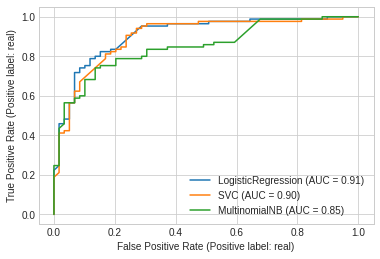

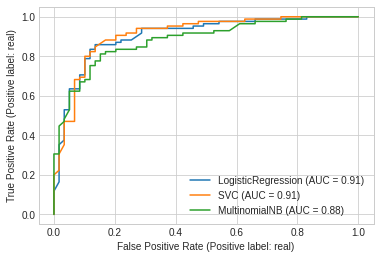

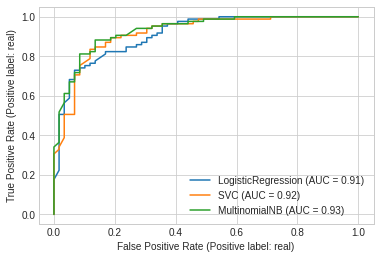

In [117]:
#TFIDF
compare_au_roc(TfidfVectorizer(), X_train, y_train, X_test, y_test) #text_clean
plt.savefig('TFIDF_text.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)
compare_au_roc(TfidfVectorizer(), X1_train, y1_train, X1_test, y1_test) #text_and_title
plt.savefig('TFIDF_text_title.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)
compare_au_roc_enc(TfidfVectorizer(), X1_train, y1_train, X1_test, y1_test) #publisher and text_and_title
plt.savefig('TFIDF_publisher.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

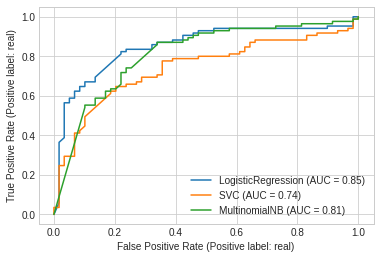

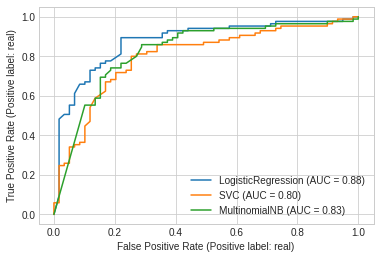

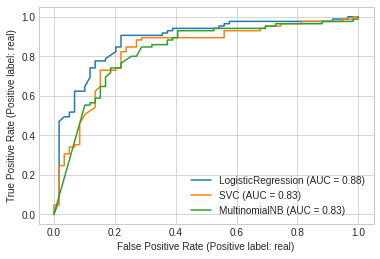

In [118]:
#Count Vectorizer
compare_au_roc(CountVectorizer(), X_train, y_train, X_test, y_test) #text_clean
plt.savefig('CV_text.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)
compare_au_roc(CountVectorizer(), X1_train, y1_train, X1_test, y1_test) #text_and_title
plt.savefig('CV_text_title.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)
compare_au_roc_enc(CountVectorizer(), X1_train, y1_train, X1_test, y1_test) #publisher and text_and_title
plt.savefig('CV_publisher.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: Futur

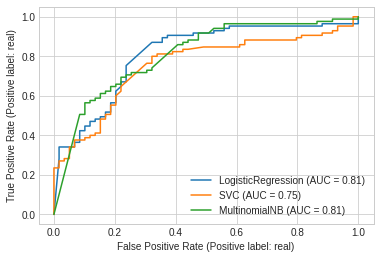

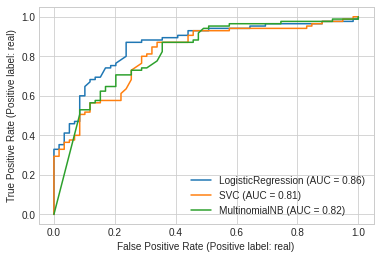

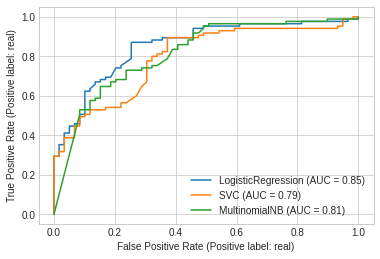

In [119]:
#Bi grams
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
compare_au_roc(bigram_converter, X_train, y_train, X_test, y_test) #text_clean
plt.savefig('Bg_text.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)
compare_au_roc(bigram_converter, X1_train, y1_train, X1_test, y1_test) #text_and_title
plt.savefig('Bg_text_title.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)
compare_au_roc_enc(bigram_converter, X1_train, y1_train, X1_test, y1_test) #publisher and text_and_title
plt.savefig('Bg_publisher.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)

# Scatterplot of Accuracy against F1-score

In [120]:
def plot_scatterplot(NB_dict, LR_dict, SVM_dict):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    plt.xlabel('Accuracy')
    plt.ylabel('F1 score')
    count = 0
    for x, y in NB_dict.values():
        if count == 0:
            ax1.scatter(x, y, marker="s", c="r", label="NB_TFIDF")
        elif count == 1:
            ax1.scatter(x, y, marker="s", c="b", label="NB_CV")
        else:
            ax1.scatter(x, y, marker="s", c="g", label="NB_bigrams")
        count+=1
    count = 0
    for x, y in LR_dict.values():
        if count == 0:
            ax1.scatter(x, y, marker="o", c="r", label="LR_TFIDF")
        elif count == 1:
            ax1.scatter(x, y, marker="o", c="b", label="LR_CV")
        else:
            ax1.scatter(x, y, marker="o", c="g", label="LR_bigrams")
        count+=1
    count = 0
    for x, y in SVM_dict.values():
        if count == 0:
            ax1.scatter(x, y, marker="^", c="r", label="SVM_TFIDF")
        elif count == 1:
            ax1.scatter(x, y, marker="^", c="b", label="SVM_CV")
        else:
            ax1.scatter(x, y, marker="^", c="g", label="SVM_bigrams")
        count+=1
    plt.legend(fontsize = 8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

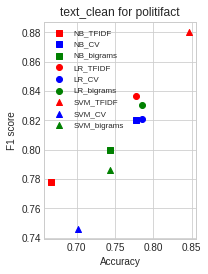

In [136]:
#text_clean
plot_scatterplot(NB_dict_a, LR_dict_a, SVM_dict_a)
plt.title('text_clean for politifact')
plt.savefig('Scatterplot_a_pf.png')
files.download("Scatterplot_a_pf.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

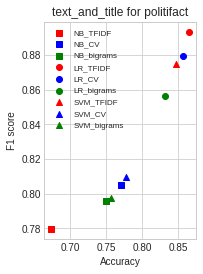

In [137]:
#text_and_title
plot_scatterplot(NB_dict_b, LR_dict_b, SVM_dict_b)
plt.title('text_and_title for politifact')
plt.savefig('Scatterplot_b_pf.png')
files.download("Scatterplot_b_pf.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

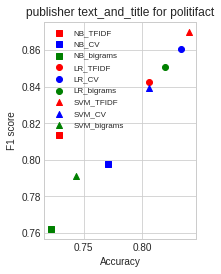

In [138]:
#publisher with text_and_title
plot_scatterplot(NB_dict_c, LR_dict_c, SVM_dict_c)
plt.title('publisher text_and_title for politifact')
plt.savefig('Scatterplot_c_pf.png')
files.download("Scatterplot_c_pf.png") 

# Writing accuracy values into a dataframe

In [124]:
acc_scores = []

for acc, f1 in SVM_dict_a.values():
    acc_scores.append(acc)
for acc, f1 in SVM_dict_b.values():
    acc_scores.append(acc)
for acc, f1 in SVM_dict_c.values():
    acc_scores.append(acc)
for acc, f1 in LR_dict_a.values():
    acc_scores.append(acc)
for acc, f1 in LR_dict_b.values():
    acc_scores.append(acc)
for acc, f1 in LR_dict_c.values():
    acc_scores.append(acc)
for acc, f1 in NB_dict_a.values():
    acc_scores.append(acc)
for acc, f1 in NB_dict_b.values():
    acc_scores.append(acc)
for acc, f1 in NB_dict_c.values():
    acc_scores.append(acc)

In [125]:
features = ['ML methods', 'text TF-IDF', 'text Count Vectorizer', 'text Bigrams', 
            'text_and_title TF-IDF', 'text_and_title Count Vectorizer', 'text_and_title Bigrams',
            'publisher, text_and_title TF-IDF', 'publisher, text_and_title Count Vectorizer', 'publisher, text_and_title Bigrams']

In [133]:
acc_matrix = pd.DataFrame(columns = features)
acc_matrix.loc[0] = ['SVM'] + acc_scores[:9]
acc_matrix.loc[1] = ['Logistic Regression'] + acc_scores[9:18]
acc_matrix.loc[2] = ['Naive Bayes'] + acc_scores[18:]

acc_matrix.to_csv('Accuracy.csv', encoding = 'utf-8-sig') 
files.download('Accuracy.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [127]:
acc_matrix

,ML methods,text TF-IDF,text Count Vectorizer,text Bigrams,text_and_title TF-IDF,text_and_title Count Vectorizer,text_and_title Bigrams,"publisher, text_and_title TF-IDF","publisher, text_and_title Count Vectorizer","publisher, text_and_title Bigrams"
0,SVM,0.847222,0.701389,0.743056,0.847222,0.777778,0.756944,0.840278,0.805556,0.743056
1,Logistic Regression,0.777778,0.784722,0.784722,0.866109,0.857741,0.832636,0.805556,0.833333,0.819444
2,Naive Bayes,0.666667,0.777778,0.743056,0.673611,0.770833,0.750000,0.729167,0.770833,0.722222


In [128]:
f1_scores = []

for acc, f1 in SVM_dict_a.values():
    f1_scores.append(f1)
for acc, f1 in SVM_dict_b.values():
    f1_scores.append(f1)
for acc, f1 in SVM_dict_c.values():
    f1_scores.append(f1)
for acc, f1 in LR_dict_a.values():
    f1_scores.append(f1)
for acc, f1 in LR_dict_b.values():
    f1_scores.append(f1)
for acc, f1 in LR_dict_c.values():
    f1_scores.append(f1)
for acc, f1 in NB_dict_a.values():
    f1_scores.append(f1)
for acc, f1 in NB_dict_b.values():
    f1_scores.append(f1)
for acc, f1 in NB_dict_c.values():
    f1_scores.append(f1)

In [134]:
f1_matrix = pd.DataFrame(columns = features)
f1_matrix.loc[0] = ['SVM'] + f1_scores[:9]
f1_matrix.loc[1] = ['Logistic Regression'] + f1_scores[9:18]
f1_matrix.loc[2] = ['Naive Bayes'] + f1_scores[18:]
f1_matrix.to_csv('f1_scores.csv', encoding = 'utf-8-sig') 
files.download('f1_scores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [130]:
f1_matrix

,ML methods,text TF-IDF,text Count Vectorizer,text Bigrams,text_and_title TF-IDF,text_and_title Count Vectorizer,text_and_title Bigrams,"publisher, text_and_title TF-IDF","publisher, text_and_title Count Vectorizer","publisher, text_and_title Bigrams"
0,SVM,0.880435,0.745562,0.786127,0.875000,0.809524,0.797688,0.870056,0.839080,0.790960
1,Logistic Regression,0.836735,0.820809,0.830601,0.893333,0.879433,0.856115,0.842697,0.860465,0.850575
2,Naive Bayes,0.777778,0.820225,0.800000,0.779343,0.804734,0.795455,0.813397,0.797546,0.761905


In [135]:
auc_matrix = pd.DataFrame(columns = ['Features and vect','SVM', 'Logistic Regression', 'Naive Bayes'])
auc_matrix.loc[0] = ['text TF-IDF'] + roc_auc_scores[:3]
auc_matrix.loc[1] = ['text_and_title TF-IDF'] + roc_auc_scores[3:6]
auc_matrix.loc[2] = ['publisher, text_and_title TF-IDF'] + roc_auc_scores[6:9]
auc_matrix.loc[3] = ['text Count Vectorizer'] + roc_auc_scores[9:12]
auc_matrix.loc[4] = ['text_and_title Count Vectorizer'] + roc_auc_scores[12:15]
auc_matrix.loc[5] = ['publisher, text_and_title Count Vectorizer'] + roc_auc_scores[15:18]
auc_matrix.loc[6] = ['text TBigrams'] + roc_auc_scores[18:21]
auc_matrix.loc[7] = ['text_and_title Bigrams'] + roc_auc_scores[21:24]
auc_matrix.loc[8] = ['publisher, text_and_title Bigrams'] + roc_auc_scores[24:]

auc_matrix.to_csv('ROC_AUC_scores.csv', encoding = 'utf-8-sig') 
files.download('ROC_AUC_scores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [132]:
auc_matrix

,Features and vect,SVM,Logistic Regression,Naive Bayes
0,text TF-IDF,0.898106,0.908674,0.849053
1,text_and_title TF-IDF,0.910668,0.905683,0.882752
2,"publisher, text_and_title TF-IDF",0.917448,0.910867,0.931406
3,text Count Vectorizer,0.741176,0.850150,0.809571
4,text_and_title Count Vectorizer,0.799801,0.876969,0.827318
5,"publisher, text_and_title Count Vectorizer",0.831306,0.884347,0.826919
6,text TBigrams,0.754636,0.810768,0.808475
7,text_and_title Bigrams,0.813161,0.858225,0.816251
8,"publisher, text_and_title Bigrams",0.793819,0.852443,0.814257
